In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
from mplfinance.original_flavor import candlestick_ohlc 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Dropout

In [44]:
df = pd.read_csv('BTC-USD.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date',inplace=True)
# df.head()
featured_columns = ['Open','High','Low','Close','Volume']
X= df[featured_columns].values
y= df['Close'].values
X_train,X_temp,y_train,y_temp = train_test_split(X,y,test_size=0.3,shuffle=False)
X_val,X_test,y_val,y_test = train_test_split(X_temp,y_temp,test_size=0.5,shuffle=False)

In [45]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Define the sequence length (e.g., 5 days of historical data)
sequence_length = 5

# Create sequences and corresponding target values
X_sequences, y_targets = [], []
for i in range(sequence_length, len(X)):
    X_sequences.append(X[i - sequence_length:i])
    y_targets.append(y[i])

X_sequences = np.array(X_sequences)
y_targets = np.array(y_targets)

# Split the data into training, validation, and test sets
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

num_samples = len(X_sequences)
num_train = int(train_ratio * num_samples)
num_val = int(val_ratio * num_samples)

X_train, y_train = X_sequences[:num_train], y_targets[:num_train]
X_val, y_val = (
    X_sequences[num_train:num_train + num_val],
    y_targets[num_train:num_train + num_val],
)
X_test, y_test = X_sequences[num_train + num_val:], y_targets[num_train + num_val:]


In [46]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50,return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam',loss='mean_squared_error')

model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/50
30/30 [==============================] - 9s 87ms/step - loss: 29502278.0000 - val_loss: 156052352.0000
Epoch 2/50
30/30 [==============================] - 0s 16ms/step - loss: 29336170.0000 - val_loss: 155258320.0000
Epoch 3/50
30/30 [==============================] - 0s 12ms/step - loss: 29109944.0000 - val_loss: 154649904.0000
Epoch 4/50
30/30 [==============================] - 0s 13ms/step - loss: 28900550.0000 - val_loss: 153963248.0000
Epoch 5/50
30/30 [==============================] - 0s 14ms/step - loss: 28666132.0000 - val_loss: 153181232.0000
Epoch 6/50
30/30 [==============================] - 0s 13ms/step - loss: 28400618.0000 - val_loss: 152305440.0000
Epoch 7/50
30/30 [==============================] - 0s 13ms/step - loss: 28103090.0000 - val_loss: 151323808.0000
Epoch 8/50
30/30 [==============================] - 0s 14ms/step - loss: 27776550.0000 - val_loss: 150239520.0000
Epoch 9/50
30/30 [==============================] - 0s 13ms/step - loss: 27422762.0000 -

In [47]:
prediction = model.predict(X_test)

13/13 [==============================] - 1s 5ms/step


In [48]:
mse = mean_squared_error(y_test, prediction)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 1863783231.7865865


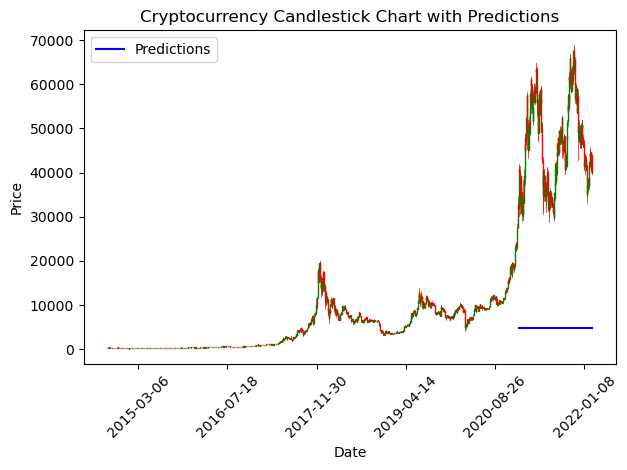

In [49]:
candlestick_df = df.copy()
candlestick_df['Date'] = mdate.date2num(candlestick_df['Date'])
ohlc = candlestick_df[['Date', 'Open', 'High', 'Low', 'Close']].values

fig,ax = plt.subplots()
candlestick_ohlc(ax,ohlc,width=0.6,colorup='g',colordown='r')
ax.plot(candlestick_df['Date'][num_train + num_val + sequence_length:], prediction, label='Predictions', color='blue')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_title('Cryptocurrency Candlestick Chart with Predictions')
ax.legend()
ax.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()